### Imports

In [22]:
from torch import (torch,nn)
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
import numpy as np

In [55]:
# Checking if mac uses MPS
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device.type)

True
True
mps


In [284]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 10
dataset_path = "../dataset"

In [285]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Grayscale()
])

dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset,[train_size,test_size])

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {"train": train_dataloader, "test": test_dataloader}

In [286]:
classes = dataset.classes
no_of_classes = len(classes)
print(f"Total classes = {no_of_classes}\nClasses = {classes}")

Total classes = 36
Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [287]:
def imshow(ax, img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')

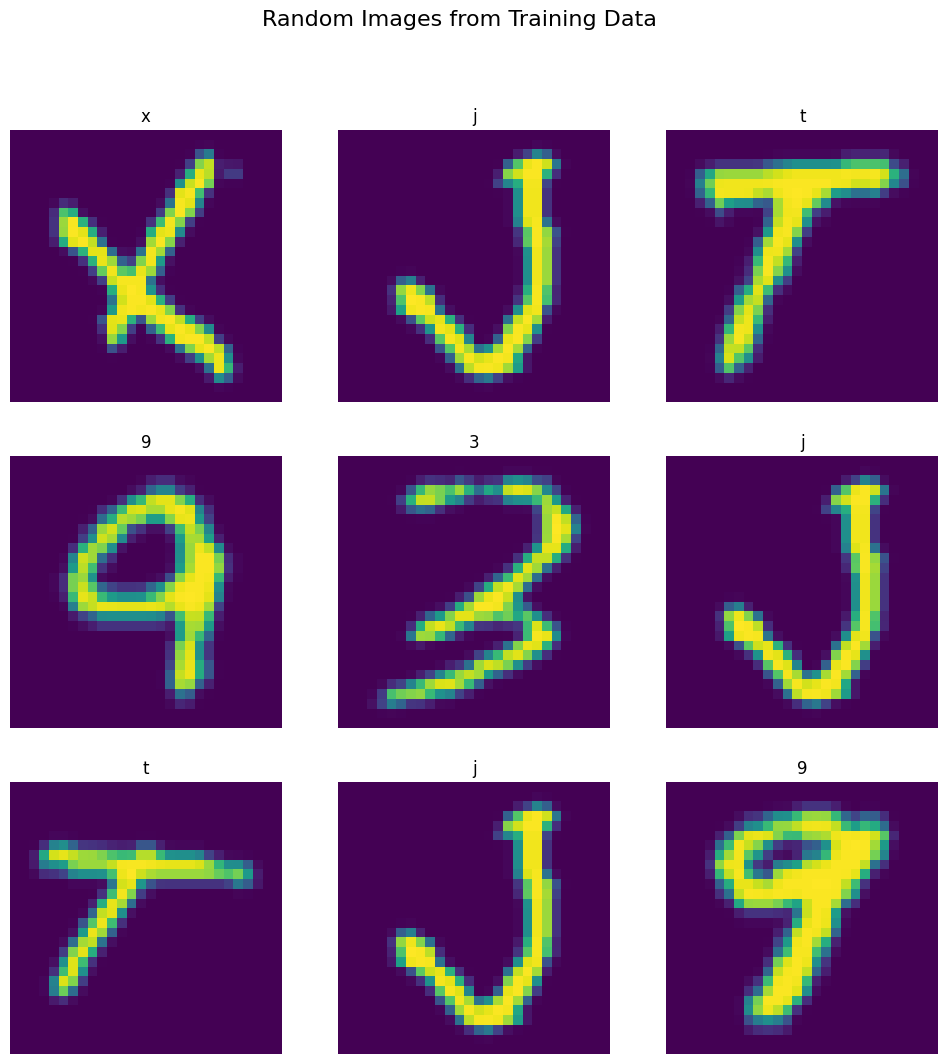

In [288]:
# Get some random training images
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Images from Training Data', fontsize=16)

for i in range(3):
    for j in range(3):
        index = np.random.randint(BATCH_SIZE)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

### Defining Model

In [325]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # parameters for Convolutional Layers
        filter_dim = 3
        in_channels = [1, 64, 56]
        out_channels = [64, 56, 40]
        pool_dim = 2

        # initializing all the layers
        self.c1 = nn.Conv2d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=filter_dim, padding="same")
        self.c2 = nn.Conv2d(in_channels=in_channels[1], out_channels=out_channels[1], kernel_size=filter_dim, padding="same")
        self.c3 = nn.Conv2d(in_channels=in_channels[2], out_channels=out_channels[2], kernel_size=filter_dim, padding="same")

        self.batch_norm1 = nn.BatchNorm2d(out_channels[0])
        self.batch_norm2 = nn.BatchNorm2d(out_channels[1])
        self.batch_norm3 = nn.BatchNorm2d(out_channels[2])

        self.dropout = nn.Dropout(0.2)

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=pool_dim)

        self.fc = nn.Linear(out_channels[2] * 3 * 3, num_classes)

        self.softmax = nn.Softmax(dim=1)  


    def forward(self, X):
        x = self.c1(X)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.c2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.c3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = x.view(32, -1)

        x = self.fc(x)
        x = self.softmax(x)

        return x


In [326]:
model = CNNModel(num_classes=no_of_classes).to(device)
print(model.parameters)

<bound method Module.parameters of CNNModel(
  (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c3): Conv2d(56, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=360, out_features=36, bias=True)
  (softmax): Softmax(dim=1)
)>


In [327]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [328]:
# Initialize lists to store training and validation metrics
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

best_val_acc = 0.0

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 30)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = corrects.double() / total_samples

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in history lists
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)
        else:
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)

        # Save the model if it has the best validation accuracy
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_weights = model.state_dict()


Epoch 1/10
------------------------------


KeyboardInterrupt: 